# Embedding and Bias Analysis

related to https://stdm.github.io/downloads/papers/ANNPR_2020.pdf

### Insights

- The cluster scores from the paper indicate that the clusters are not structured
- The centers of clusters span a 3d spaces. The projection of the clusters into this 3d spaces shows nice clustering. The 4 clusters roughly arrange as a pyramid
- The 3d projection is missleading. The 3d-distances are only fraction of the full distances. The full distances are dominated by the rest of the dimension.
- This is also confirmed in terms of variance
- The behavior of distance is dominated by high-dimensional behavior, which explains the following inequality: 
        nearest neighebor distances between clusters < pairwise distances within a single cluster

**I think that the structering of the clusters in these high dimensional spaces is negligibable, maybe the distribution of the variance over the dimensions shows more insights...** 

### Literatur, Links
- https://towardsdatascience.com/introduction-to-best-parallel-plot-python-library-hiplot-8387f5786d97
- https://machinelearningmastery.com/how-to-perform-face-recognition-with-vggface2-convolutional-neural-network-in-keras/



### Import and Helpers

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import hiplot as hip
from sklearn.decomposition import PCA
from sklearn.neighbors import DistanceMetric
from sklearn.neighbors import NearestNeighbors
from scipy.linalg import orth
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score

mystore = r'C:\Daten\_tmp\FRdata.h5'

In [2]:
class H5Reader:
    pattern = r'C:\Daten\FaceRecognitionBias\senet50\embeddings\{net}_pytorch_{race}_normed_BGR.h5'
    race_list = ['Caucasian','Indian','Asian','African']
    net_list = ['senet50_128','senet50_256','senet50_ft']
    hdf_key = '/embeddings'
    
    def __init__(self, net):
        self.net = net
        
    @classmethod
    def net(cls, ind):
        return cls.net_list[ind]
        
    @classmethod
    def race(cls, ind):
        if type(ind) == str:
            return list(filter(lambda s: s.lower().startswith(ind.lower()),cls.race_list))[0]
        else:
            return cls.race_list[ind]
        
    def path(self, race):
        race = list(filter(lambda s: s.lower().startswith(race.lower()),self.race_list))[0]
        return self.pattern.format(net = self.net, race = race)
        
    def read(self, race_prefix, race_index = False):
        race = self.race(race_prefix)
        path = self.pattern.format(net = self.net, race = race)
        df = pd.read_hdf(path, self.hdf_key)
        if race_index:
            df['race_index'] = self.race_list.index(race)
        return df
    
    def read_all(self, N=None, select = 'head'):
        out = []
        for race in self.race_list:
            df = self.read(race, race_index=True)
            if N is None:
                out.append(df)
            elif select == 'head':
                out.append(df.head(N))
            else:
                out.append(df.tail(N))    
                
        return pd.concat(out,0).set_index('race_index').reset_index()
                
    def keys(self, race_prefix):    
        race = self.race(race_prefix)
        path = self.pattern.format(net = self.net, race = race)
        with pd.HDFStore(path) as hdf:
            out = hdf.keys()
        return out
    
r128 = H5Reader('senet50_128')
r128.keys('c')

['/embeddings', '/images', '/no_face_found_df']

# 0. Interpretaion of the cluster scores 

I wonder what cluster with the same scores look like in 2d. Therefore i create two clusters out of uniform random point seperated by a distance of 1 (see figure). In order to get similar scores as in the paper, the clusters have to be very badly structured... [Wikipedia](https://de.wikipedia.org/wiki/Silhouettenkoeffizient) confirms this for the values of the Silhouette score: 

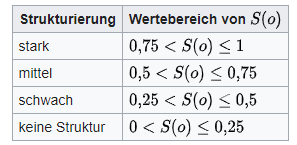

In [247]:
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score

def calculate_scores(X, labels):
    return {'MS': silhouette_score(X, labels),
            'CH': calinski_harabasz_score(X, labels),
            'DB': davies_bouldin_score(X, labels)}

def uniform_2d_clusters(w,N=1000):
    labels = np.int8(np.arange(2*N)/N)
    X = np.concatenate([labels.reshape([-1,1]),w*np.random.uniform(size=[2*N,1])],1)
    return X, labels

score_df = []
for w in [5,10,20,50,100]:
    X, labels = uniform_2d_clusters(w)    
    out = calculate_scores(X, labels)
    score_df.append(pd.DataFrame(pd.Series(out),columns=[w]))
score_df = pd.concat(score_df,1).T
score_df

,MS,CH,DB
5,0.192783,235.166975,2.530582
10,0.076756,63.423205,4.831534
20,0.024196,15.923777,9.748960
50,0.005084,2.644784,23.675935
100,0.002259,0.647250,48.019620


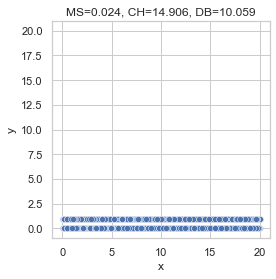

In [257]:
N = 20
X, labels = uniform_2d_clusters(20)
df = pd.DataFrame(labels, columns=['label'])
df['x'] = X[:,1]
df['y'] = X[:,0]
scores = calculate_scores(X,labels)
g = sns.scatterplot(x='x',y='y',data=df)
g.set(xlim=[-1,N+1],ylim=[-1,N+1],aspect = 1)
plt.title(', '.join([key+'='+str(np.round(val,3)) for key,val in scores.items()]))
plt.show()

# 1. Subspace projection (3D) for senet50_128

In a first step I project the empeddings into a 3D-space spannend by the centers (averages) of the clusters. As a result I get beautifully structured clusters.

In [258]:
# Projection into 3D space spanned by the 4 centers of the clusters 
def projection3d(df):
    center_df = df.groupby(['race_index']).mean()
    B = orth((center_df[1:].values - center_df[:1].values).T)
    X = df.filter(regex = r'\d').values
    P = np.dot(X,B)
    return pd.concat([df.filter(regex=r'\D').copy(), pd.DataFrame(P)],1)  # ,columns=['P'+str(k) for k in range(3)]

rd = H5Reader('senet50_128')
df = rd.read_all(9500)
P3d_df = projection3d(df).rename(columns={0:'P0',1:'P1',2:'P2'})
P3d_df['race'] = P3d_df.race_index.apply(H5Reader.race)
P3d_df.head()

,race_index,P0,P1,P2,race
0,0,-0.239186,-0.059864,-0.116899,Caucasian
1,0,-0.208332,-0.074734,-0.071194,Caucasian
2,0,-0.197876,-0.076869,-0.121779,Caucasian
3,0,-0.150470,-0.114207,-0.050618,Caucasian
4,0,-0.079658,-0.097424,-0.043311,Caucasian


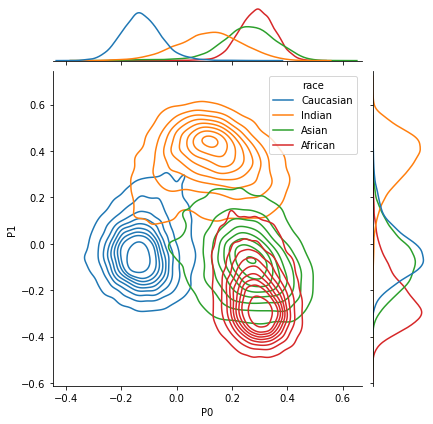

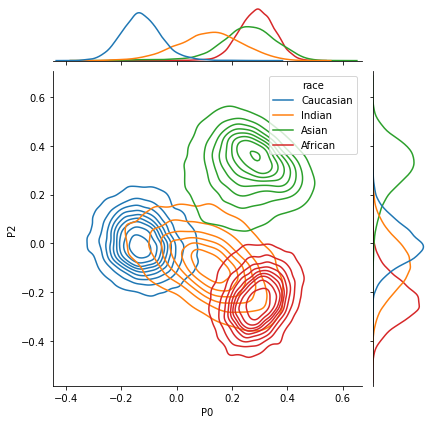

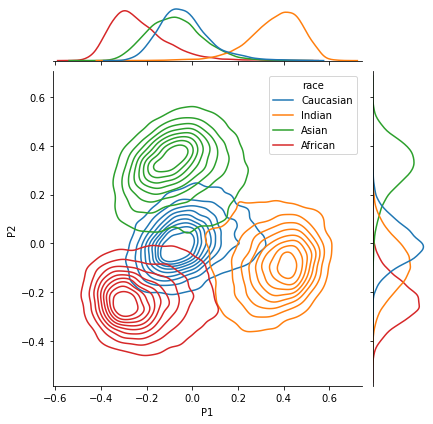

In [4]:
%matplotlib inline
sns.jointplot(x='P0', y='P1',hue='race',data=P3d_df,kind="kde")
plt.show()
sns.jointplot(x='P0', y='P2',hue='race',data=P3d_df,kind="kde")
plt.show()
sns.jointplot(x='P1', y='P2',hue='race',data=P3d_df,kind="kde")
plt.show()

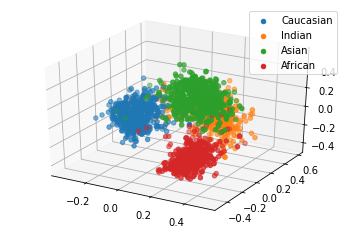

In [5]:
# %matplotlib notebook
N = 500
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for ir in P3d_df.race_index.unique():
    sel = P3d_df.race_index == ir
    ax.scatter(P3d_df[sel]['P0'][:N], P3d_df[sel]['P1'][:N], P3d_df[sel]['P2'][:N],label=H5Reader.race(ir))
ax.legend()

# 2. Distance Analysis

### Insights
- abc

### Next Steps
- [x] Alles mit Euklidischer Distanz rechnen
- [x] Nur die nächsten Nachbarn anschauen
- [x] Make nearest neighbor plot over all three nets
- [ ] Further investigate confusion matrices


## 2.1 Preprocessing 
 
Time consuming calculations. Results stored to hdf

In [32]:
# calculate euclidean distances between clusters
N = 300
df = []
dist = DistanceMetric.get_metric('euclidean')
for inet, net in enumerate(H5Reader.net_list):
    rd = H5Reader(net)
    for irace, race1 in enumerate(H5Reader.race_list):
        for jrace,race2 in enumerate(H5Reader.race_list):
            X1 = rd.read(race1).head(N).values
            X2 = rd.read(race2).tail(N).values
            distances =dist.pairwise(X1,X2).flatten().astype(np.float32)
            new_df = pd.DataFrame(distances,columns = ['distance'])
            new_df['net_index'] = np.int8(inet)
            new_df['race_index1'] = np.int8(irace)
            new_df['race_index2'] = np.int8(jrace)
            df.append(new_df)
            
# save to store
df = pd.concat(df,0)
df.to_hdf(mystore,'cluster_eucl_distances')

In [33]:
# calculate euclidean distances between clusters for 3d projection
N = 300
df = []
dist = DistanceMetric.get_metric('euclidean')
for inet, net in enumerate(H5Reader.net_list):
    rd = H5Reader(net)
    raw_df = projection3d(rd.read_all())
    for irace, race1 in enumerate(H5Reader.race_list):
        for jrace,race2 in enumerate(H5Reader.race_list):
            X1 = raw_df.query('race_index==@irace').filter(regex=r'\d').head(N).values
            X2 = raw_df.query('race_index==@jrace').filter(regex=r'\d').tail(N).values
            distances =dist.pairwise(X1,X2).flatten().astype(np.float32)
            new_df = pd.DataFrame(distances,columns = ['distance'])
            new_df['net_index'] = np.int8(inet)
            new_df['race_index1'] = np.int8(irace)
            new_df['race_index2'] = np.int8(jrace)
            df.append(new_df)
            
# save to store
df = pd.concat(df,0)
df.to_hdf(mystore,'cluster_eucl_distances_3d')

In [25]:
# !!!!!!!!!! TAKES HOURS TO RUN !!!!!!!!!!!!!!!!!
# calculate nearest neighbor euclidean distances between clusters
N = 9500 # much higher for nearest neighbor distances
df = []
for inet, net in enumerate(H5Reader.net_list):
    rd = H5Reader(net)
    for irace, race1 in enumerate(H5Reader.race_list):
        for jrace,race2 in enumerate(H5Reader.race_list):
            X1 = rd.read(race1).head(N).values
            X2 = rd.read(race2).head(N).values
            n_neighbors = 2 if race1 == race2 else 1            
            neigh = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree')
            neigh.fit(X1)
            distances, indices = neigh.kneighbors(X2)
            new_df = pd.DataFrame(distances[:,-1], columns=['distance'])
            new_df['nn_index'] = indices[:,-1]
            new_df['net_index'] = np.int8(inet)
            new_df['race_index1'] = np.int8(irace)
            new_df['race_index2'] = np.int8(jrace)
            df.append(new_df)

# save to store
df = pd.concat(df,0)
df.to_hdf(mystore,'nn_eucl_distances')

## 2.2 Distance distributions 

Plots in this section show
- Violin plots of (euclidean) distance distribution
- The distances are between points of same clusters (diagonal case) or between points of different clusters (off-diagonal cas)
- The distributions represent either all pairwise distances (pair case) or distances to neares neighbors (nn case)

C:\Users\wehs\.conda\envs\ds\lib\site-packages\seaborn\axisgrid.py:645: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\Users\wehs\.conda\envs\ds\lib\site-packages\seaborn\axisgrid.py:650: UserWarning: Using the violinplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


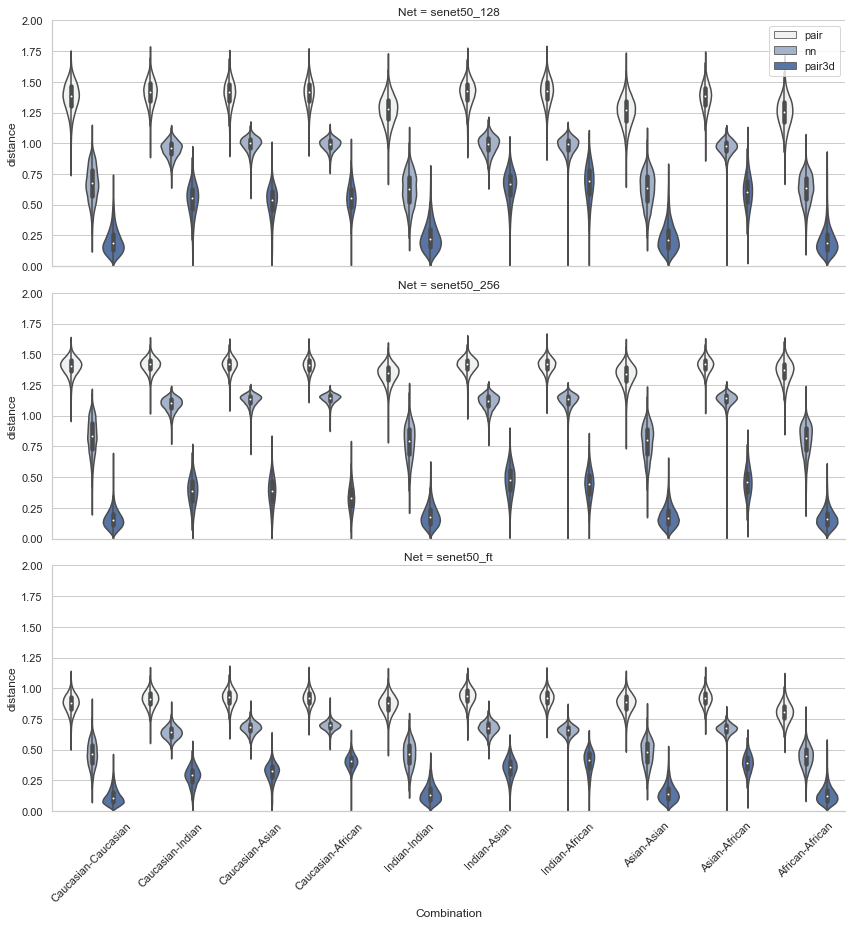

In [38]:
%matplotlib inline
df = pd.concat(
    [pd.read_hdf(mystore,'cluster_eucl_distances').assign(type1='pair'),
     pd.read_hdf(mystore,'nn_eucl_distances').assign(type1='nn'),
     pd.read_hdf(mystore,'cluster_eucl_distances_3d').assign(type1='pair3d')
     ],0).query('race_index2 >= race_index1')
df['Combination'] = df.race_index1.apply(H5Reader.race) + '-' + df.race_index2.apply(H5Reader.race)
df['Net'] = df.net_index.apply(H5Reader.net)

sns.set_theme(style="whitegrid")
g = sns.FacetGrid(df,row='Net',aspect=3,height=4, legend_out=True)
g.map(sns.violinplot, 'Combination','distance','type1')
g.set(ylim=(0, 2))
g.set_xticklabels(rotation=45)
g.fig.get_axes()[0].legend()

### Condensed distributions

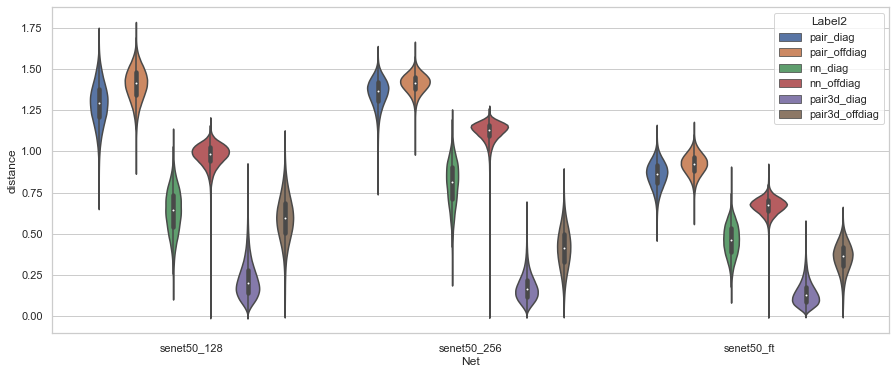

In [39]:
df['type2'] = (df.race_index1 == df.race_index2).apply(lambda b: 'diag' if b else 'offdiag')
df['Label2'] = df.type1 + '_' + df.type2
plt.figure(figsize=(15,6))
sns.violinplot(x='Net',y='distance',hue='Label2',data=df)

### Fraction of points which are nearest neighbors

In off-diagonal distances, still 30% of points are nearest neighbors!

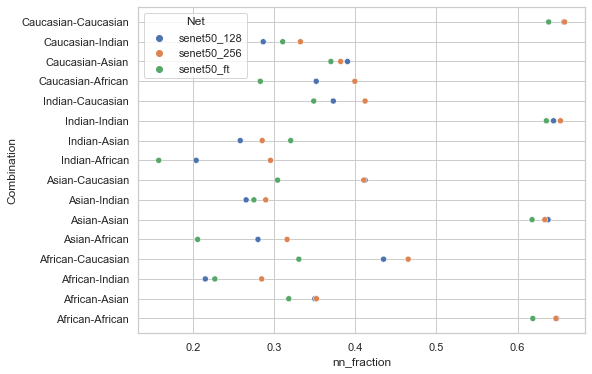

In [186]:
tmp = (df.query("type1=='nn'")
     .groupby(['net_index','race_index1','race_index2'])
     .apply(lambda df: pd.Series({'nn_fraction':len(df.nn_index.unique())/9500,
                                  'Combination':df.Combination[0],
                                 'Net':df.Net[0]})))
tmp = pd.DataFrame(tmp).reset_index()
plt.figure(figsize=(8,6))
g = sns.scatterplot(y='Combination',x='nn_fraction',hue='Net',data=tmp)

# 3. Variance and PCA

### Next Steps
- [x] Einfluss von Solvern, Accuracy -> Bei solver 'full' gibt es keine Einstellungen
- [ ] Normalisierung & Intercept für PCA untersuchen
- [ ] Knick bei senett50_ft untersuchen
- [ ] Alternative Masse im Zusammenhang mit Varianz & PCA untersuchen. Klären, was die geom. Interpretation ist.
- [ ] Verschiedene Arten von Varianze-Rechnung einführen (ev. PCA für gasammte Daten und dann Projektion). Rumspielen. Geom sinnvoll interpretieren.

## 2.1. Variance analysis

- The 3d projection only contributes a fraction to the total variance
- The variation of the variance of each cluster does modestly correlate with the variation in the recognition rate

In [291]:
vardf = []
for net in H5Reader.net_list:
    df = H5Reader(net).read_all()
    df['race'] = df.race_index.apply(H5Reader.race)
    tot_var = df.filter(regex='\d').var().T.sum()
    df = df.groupby('race').var().filter(regex='\d').T.sum()
    df = pd.DataFrame(df,columns=[net])
    df.loc['Total',net] = tot_var
    vardf.append(df)
vardf = pd.concat(vardf,1)

vardf3d = []
for net in H5Reader.net_list:
    df = projection3d(H5Reader(net).read_all())
    df['race'] = df.race_index.apply(H5Reader.race)
    tot_var = df.filter(regex='\d').var().T.sum()
    df = df.groupby('race').var().filter(regex='\d').T.sum()
    df = pd.DataFrame(df,columns=[net])
    df.loc['Total',net] = tot_var
    vardf3d.append(df)
vardf3d = pd.concat(vardf3d,1)
pd.concat([vardf,vardf3d],1,keys=['full','3d projection']).reindex(H5Reader.race_list+['Total'])

full                        3d projection              \
          senet50_128 senet50_256 senet50_ft   senet50_128 senet50_256   
race                                                                     
Caucasian    0.962882    0.987675   0.394439      0.025255    0.014945   
Indian       0.826110    0.906292   0.385527      0.038815    0.023025   
Asian        0.814082    0.904100   0.394231      0.037556    0.021526   
African      0.789606    0.927298   0.328315      0.028488    0.017653   
Total        0.962497    0.985059   0.416376      0.146927    0.072818   

                      
          senet50_ft  
race                  
Caucasian   0.008927  
Indian      0.013788  
Asian       0.014903  
African     0.011973  
Total       0.053693

## 2.2 PCA, Variance spread and recognition rate

PCA calculates normalized variance $p_i$ such that $\sum p_i = 1$. Here I define a variance spread as

$$ h = \sum_i i * p_i $$

- Bigger h means that variance spreads over more components, i.e. more dimensions. 
- Below: h is calculated with a seperate pca for each class.
- Fit is done with a fit-paremeter per model

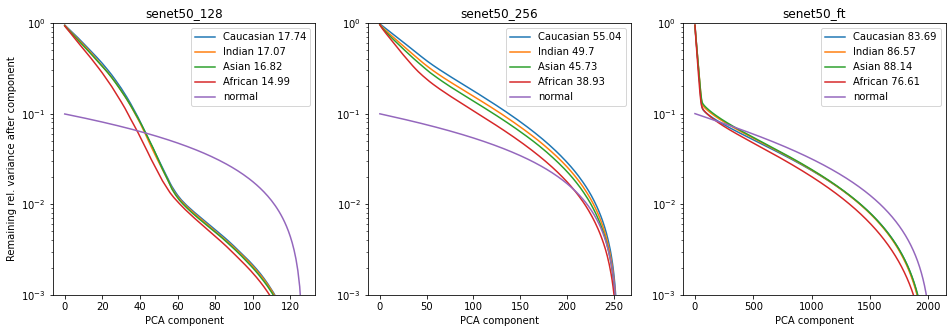

In [93]:
pca = PCA(svd_solver='full')
N=9500

hmat = np.zeros([3,4])
fig, axs = plt.subplots(1, 3, figsize=(16,5))
for inet,net in enumerate(H5Reader.net_list):
    rd = H5Reader(net)
    for irace,race in enumerate(H5Reader.race_list):
        X = rd.read(race).head(N).values
        #X = X - np.mean(X,0,keepdims=True)
        pca.fit(X)
        var = pca.explained_variance_ratio_
        #var = var/np.sum(var)
        h = np.dot(var,np.arange(len(var)))
        hmat[inet,irace]=h
        axs[inet].semilogy(1 - np.cumsum(var),label=race+' '+str(np.round(h,2)))
    
    pca.fit(np.random.normal(size=[N,X.shape[1]]))
    var = pca.explained_variance_ratio_
    axs[inet].semilogy((1 - np.cumsum(var))/10,label='normal')

    axs[inet].legend()
    axs[inet].set_title('senet50_'+net)
    axs[inet].set_ylim([0.001,1])
    #axs[inet].set_xlim([0,150])
    axs[inet].set_xlabel('PCA component')
    
    if inet == 0:
        axs[inet].set_ylabel('Remaining rel. variance after component')
    
plt.show()

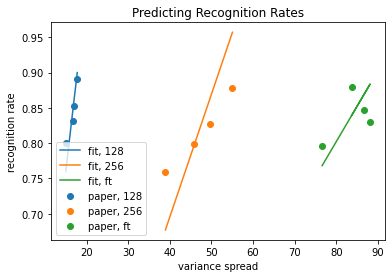

In [86]:
# recognition rate
recrate=[[0.8906,0.8531,0.8310,0.7998],
        [0.8787,0.8265,0.7981,0.7597],
        [0.8799,0.8472,0.8305,0.7959]]

recrate_fit = hmat*np.mean(recrate/hmat,1,keepdims=1)

for inet, net in enumerate(H5Reader.net_list):
    plt.scatter(hmat[inet],recrate[inet],label='paper, ' + net)
    plt.plot(hmat[inet],recrate_fit[inet],label='fit, '+net)
plt.legend()
plt.xlabel('variance spread')
plt.ylabel('recognition rate')
plt.title('Predicting Recognition Rates')
plt.show()

### Distribution functions of PCA prejections 

Here PCA was done on all classes

In [39]:
N = 9500
pca_dict = {}
for net in H5Reader.net_list:
    df = H5Reader(net).read_all()
    X = df.values[:,1:]
    pca = PCA(n_components=10)
    Xp = pca.fit_transform(X)
    pca_dict[net] = pd.concat([df.drop(columns=df.columns[1:]),pd.DataFrame(data=Xp)],1) 

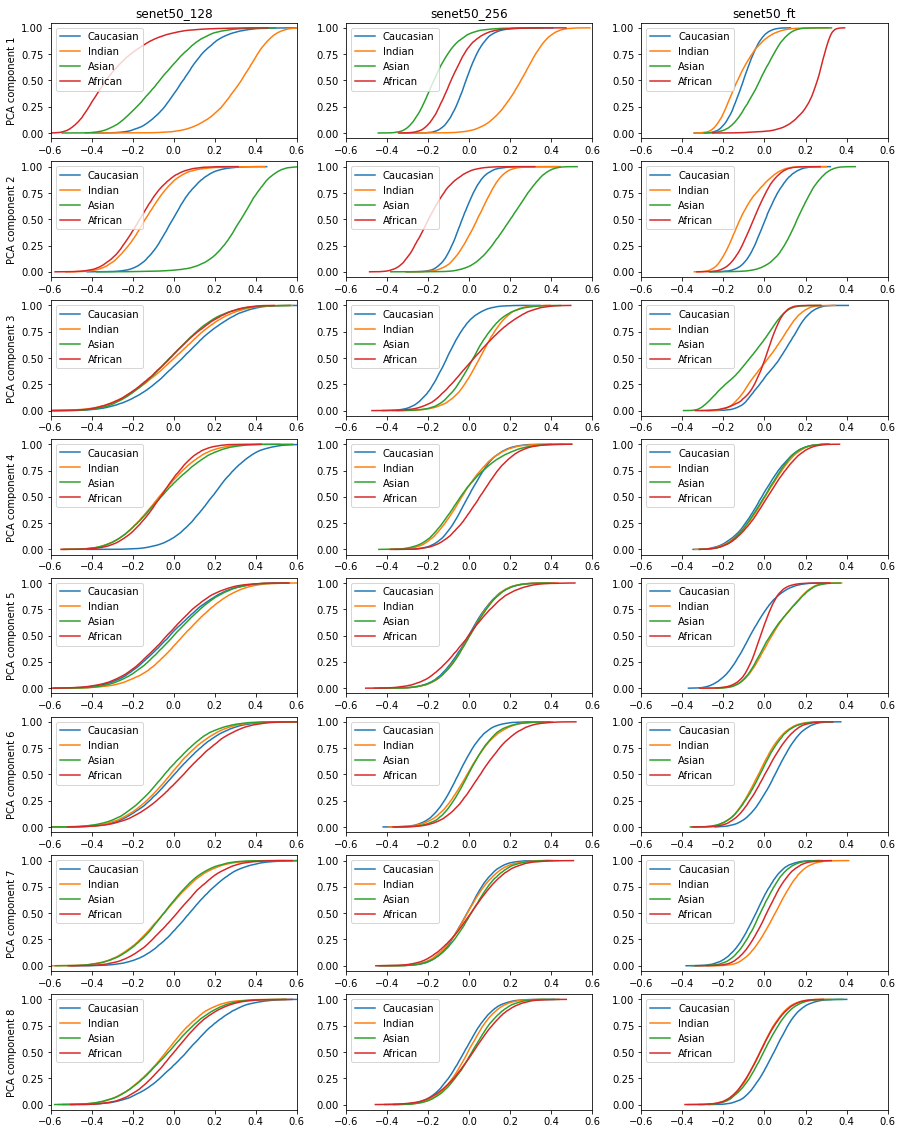

In [40]:
Npca = 8
fig, axs = plt.subplots(Npca, 3, figsize=[15,20],)
#fig.suptitle('Cosine Similarities')
for inet, net in enumerate(H5Reader.net_list):
    for ipca in range(Npca):
        for irace, race in enumerate(H5Reader.race_list):
            x, y = cumdist(pca_dict[net].query('race_index==@irace')[ipca].values)
            axs[ipca, inet].plot(x,y,label=race)
        if ipca == 0:
            axs[ipca, inet].set_title('senet50_'+net)
        axs[ipca, inet].legend(loc='upper left')
        axs[ipca,inet].set_xlim([-0.6,0.6])
        if inet == 0:
            axs[ipca,inet].set_ylabel('PCA component '+str(ipca + 1))
    
plt.savefig('pca.png',papertype='A4',dpi=200)
plt.show()